In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from scipy import constants

In [2]:
def calculate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)

def calculate_super_operator(result_dict: dict):
    rho_final = {state: result.states[-1] for state, result in result_dict.items()}
    subspace_vector_final = {state: operator_to_vector(Qobj(rho[:2,:2]))[:,:] for state, rho in rho_final.items()}
    super_op_sim = Qobj(np.column_stack((
        subspace_vector_final['00'], 
        subspace_vector_final['10'], 
        subspace_vector_final['01'], 
        subspace_vector_final['11'])))
    return super_op_sim

ideal_gate = Qobj(np.array([
    [1, 0, 0, 0],
    [0,-1, 0, 0],
    [0, 0,-1, 0],
    [0, 0, 0, 1]
]))

In [4]:
def gaussian(t, tau, sigma):
    a = np.exp(-0.5 * ((-tau / 2) / sigma)**2)
    return (np.exp(-0.5 * ((t - tau / 2) / sigma)**2) - a) / (1 - a)

def gaussian_flat_top(t, t0, tau, rise_time, k=3):
    sigma = rise_time / k
    flat_time = tau - 2 * rise_time
    
    # Compute sections with vectorized operations
    a = np.exp(-0.5 * ((-rise_time) / sigma) ** 2)
    ring_up = (np.exp(-0.5 * (((t - t0) - rise_time) / sigma) ** 2) - a) / (1 - a)
    ring_down = (np.exp(-0.5 * ((rise_time + flat_time - (t - t0)) / sigma) ** 2) - a) / (1 - a)

    # Create a mask for different regions
    ring_up_mask = (t0 <= t) & (t <= t0 + rise_time)
    flat_mask = (t > t0 + rise_time) & (t < t0 + rise_time + flat_time)
    ring_down_mask = (t >= t0 + rise_time + flat_time) & (t <= t0 + tau)

    # Initialize output array
    result = np.zeros_like(t)

    # Assign values based on masks
    result[ring_up_mask] = ring_up[ring_up_mask]
    result[flat_mask] = 1
    result[ring_down_mask] = ring_down[ring_down_mask]

    return result

In [5]:
Omega_Raman = 2 * np.pi * 4  # MHz
Delta_e01 = 2 * np.pi * 8.3983031875  # MHz
Delta_Raman = -Delta_e01 / 2  # MHz
gate_time = 1  # us
k = 3  # rise time in units of sigma
initial_states = ['00', '01', '10', '11']

def simulate_gate(
    Omega_Raman,
    Delta_e01, 
    Delta_Raman,
    gate_time, 
    rise_time, 
    num_pulses,
    num_points,
    initial_states,
    detuning_offset, 
    rise_sigma=3,
):

    basis_g0 = basis(4, 0)
    basis_g1 = basis(4, 1)
    basis_e0 = basis(4, 2)
    basis_e1 = basis(4, 3)

    H0 = 0  # time-independent
    H1 = 0  # time-dependent
    # Add detuning between 3P0 levels
    H0 += Delta_e01 * basis_e0 * basis_e0.dag()
    # Add coupling for |0>
    H1 += (Omega_Raman / 2) * (basis_g0 * basis_e0.dag() + basis_e0 * basis_g0.dag())
    # Add coupling for |1>
    H1 += (Omega_Raman / 2) * (basis_g1 * basis_e1.dag() + basis_e1 * basis_g1.dag())
    # Add drive detuning
    H0 += Delta_Raman * (basis_e0 * basis_e0.dag() + basis_e1 * basis_e1.dag())
    H0 += detuning_offset * basis_e0 * basis_e0.dag() - detuning_offset * basis_e1 * basis_e1.dag()


    def gaussian_flat_top(t, t0, tau, rise_time, k=rise_sigma):
        sigma = rise_time / k
        flat_time = tau - 2 * rise_time
        
        # Compute sections with vectorized operations
        a = np.exp(-0.5 * ((-rise_time) / sigma) ** 2)
        ring_up = (np.exp(-0.5 * (((t - t0) - rise_time) / sigma) ** 2) - a) / (1 - a)
        ring_down = (np.exp(-0.5 * ((rise_time + flat_time - (t - t0)) / sigma) ** 2) - a) / (1 - a)

        # Create a mask for different regions
        ring_up_mask = (t0 <= t) & (t <= t0 + rise_time)
        flat_mask = (t > t0 + rise_time) & (t < t0 + rise_time + flat_time)
        ring_down_mask = (t >= t0 + rise_time + flat_time) & (t <= t0 + tau)

        # Initialize output array
        result = np.zeros_like(t)

        # Assign values based on masks
        result[ring_up_mask] = ring_up[ring_up_mask]
        result[flat_mask] = 1
        result[ring_down_mask] = ring_down[ring_down_mask]

        return result
    
    
    ts = np.linspace(0, num_pulses * gate_time, num_points)
    pulse = np.zeros_like(ts)
    for i in range(num_pulses):
        pulse += gaussian_flat_top(ts, ts[i * num_points // num_pulses], gate_time, rise_time)

    def H1_coefficient(t):
        return np.interp(t, ts, pulse)

    rho_inital_dict = {
        '00': basis_g0 * basis_g0.dag(), 
        '01': basis_g0 * basis_g1.dag(), 
        '10': basis_g1 * basis_g0.dag(), 
        '11': basis_g1 * basis_g1.dag()
    }

    result_dict = {}
    for state in initial_states:
        result = mesolve(
            [H0, [H1, H1_coefficient]],
            rho_inital_dict[state], 
            ts, 
            # e_ops=list(rho_inital_dict.values()), 
            options=dict(store_states=True))
        result_dict[state] = result
        
    return result_dict


In [69]:
Omegas = 2 * np.pi * np.linspace(1.5, 2.6, 100) #4.001005025125628
rise_time = 0.5
Delta_e01 = 2 * np.pi * 8.3983031875  # MHz
Delta_Raman = -Delta_e01 / 2  # MHz
gate_time = 1  # us
num_pulses = 4
num_points = 1000
initial_states = ['00', '01', '10', '11']
ks = np.linspace(2, 4.5, 20)


optimal_Omegas = []
optimal_infidelities = []
for k in ks:
    print(k)
    # coarse sweep
    best_infidelity = 1
    best_index = 0
    for i, Omega in enumerate(Omegas):
        result_dict = simulate_gate(
            Omega,
            Delta_e01,
            -Delta_e01 / 2,
            gate_time,
            rise_time, 
            num_pulses,
            num_points * num_pulses,
            initial_states,
            detuning_offset=0,
            rise_sigma=k,
        )
        super_op = calculate_super_operator(result_dict)
        infidelity = 1 - calculate_fidelity(super_op, ideal_gate)
        if infidelity < best_infidelity:
            best_index = i
            best_infidelity = infidelity
    # fine sweep
    best_Omega = Omegas[best_index]
    fine_Omegas = np.linspace(best_Omega * 0.97, best_Omega * 1.03, 100)
    best_infidelity = 1
    best_Omega = None
    for Omega in fine_Omegas:
        result_dict = simulate_gate(
            Omega,
            Delta_e01,
            -Delta_e01 / 2,
            gate_time,
            rise_time, 
            num_pulses,
            num_points * num_pulses,
            initial_states,
            detuning_offset=0,
            rise_sigma=k,
        )
        super_op = calculate_super_operator(result_dict)
        infidelity = 1 - calculate_fidelity(super_op, ideal_gate)
        if infidelity < best_infidelity:
            best_infidelity = infidelity
            best_Omega = Omega
    optimal_infidelities.append(best_infidelity)
    optimal_Omegas.append(best_Omega)
    

2.0
2.1315789473684212
2.263157894736842
2.3947368421052633
2.526315789473684
2.6578947368421053
2.7894736842105265
2.9210526315789473
3.052631578947368
3.1842105263157894
3.3157894736842106
3.4473684210526314
3.5789473684210527
3.7105263157894735
3.8421052631578947
3.973684210526316
4.105263157894736
4.2368421052631575
4.368421052631579
4.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$\\tau_\\text{rise} / \\sigma$')

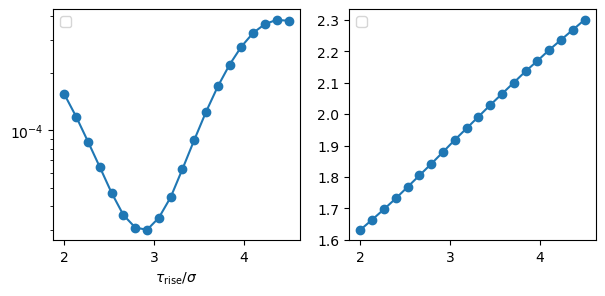

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))
ax[0].plot(ks, optimal_infidelities, 'o-')
ax[1].plot(ks, np.array(optimal_Omegas) / 2 / np.pi, 'o-')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel(r'$\tau_\text{rise} / \sigma$')

In [27]:
# optimal_infidelities_list = []
# optimal_Omegas_list = []

In [71]:
optimal_infidelities_list.append(optimal_infidelities)
optimal_Omegas_list.append(optimal_Omegas)

In [68]:
optimal_Omegas_list[0][-1] / 2 / np.pi / np.sqrt(4)
# optimal_Omegas_list[0][-1] / 2 / np.pi / np.sqrt(3)

2.4856101928374654

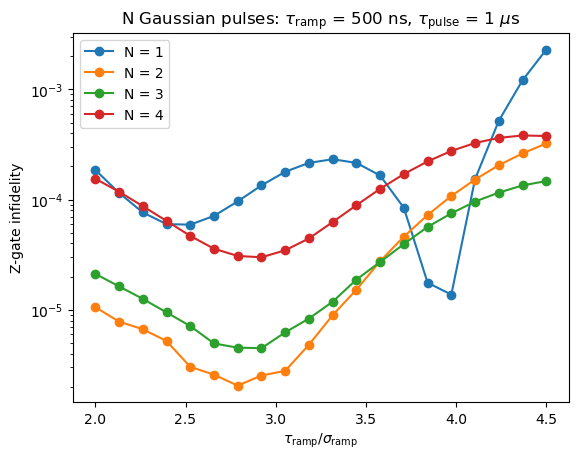

In [73]:
plt.figure()
plt.plot(ks, optimal_infidelities_list[0], 'o-', label='N = 1')
plt.plot(ks, optimal_infidelities_list[1], 'o-', label='N = 2')
plt.plot(ks, optimal_infidelities_list[2], 'o-', label='N = 3')
plt.plot(ks, optimal_infidelities_list[3], 'o-', label='N = 4')
plt.yscale('log')
plt.xlabel(r'$\tau_\text{ramp} / \sigma_\text{ramp}$')
plt.ylabel('Z-gate infidelity')
plt.title(r'N Gaussian pulses: $\tau_\text{ramp}$ = 500 ns, $\tau_\text{pulse}$ = 1 $\mu$s')
plt.legend()

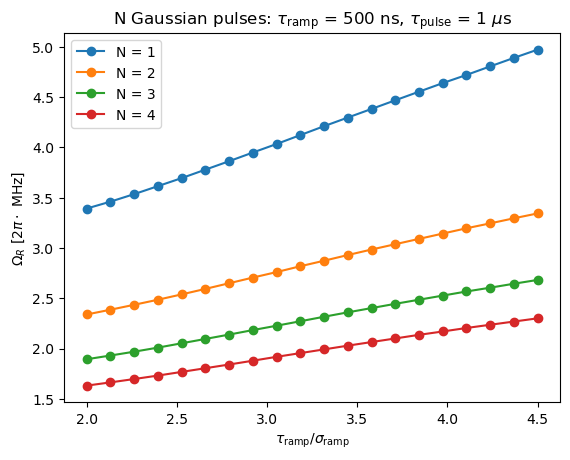

In [82]:
plt.figure()
plt.plot(ks, np.array(optimal_Omegas_list[0]) / 2 / np.pi, 'o-', label='N = 1')
plt.plot(ks, np.array(optimal_Omegas_list[1]) / 2 / np.pi, 'o-', label='N = 2')
plt.plot(ks, np.array(optimal_Omegas_list[2]) / 2 / np.pi, 'o-', label='N = 3')
plt.plot(ks, np.array(optimal_Omegas_list[3]) / 2 / np.pi, 'o-', label='N = 4')
plt.xlabel(r'$\tau_\text{ramp} / \sigma_\text{ramp}$')
plt.ylabel(r'$\Omega_R$ [$2\pi \cdot$ MHz]')
plt.title(r'N Gaussian pulses: $\tau_\text{ramp}$ = 500 ns, $\tau_\text{pulse}$ = 1 $\mu$s')
plt.legend()

In [76]:
data = {
    'rise_sigmas': ks,
    'num_pulses': [1, 2, 3, 4],
    'optimal_Omegas': optimal_Omegas_list,
    'optimal_infidelities': optimal_infidelities_list
}

import pickle
with open('data/20250204_rise_time_vs_infidelity_sweep.pkl', 'wb') as f:
    pickle.dump(data, f)

In [80]:
with open('data/20250204_rise_time_vs_infidelity_sweep.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
leakages = []
infidelities = []

for result_dict in result_dicts:

    super_op = calculate_super_operator(result_dict)
    fidelity = calculate_fidelity(super_op, ideal_gate)

    vec = np.array(super_op[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    
    leakages.append(leakage)
    infidelities.append(1-fidelity)
    
idx = np.argmin(infidelities)
Omegas[idx] / 2 / np.pi
infidelities[idx]
leakages[idx]

In [ ]:
num_pulses_arr = [1, 2, 3, 4, 5, 6, 7, 8]

Omega_optimals_4sigma = [
    4.654747474747475,
    3.1543434343434344,
    2.536262626262626,
    2.1783838383838385,
    1.9393939393939392,
    1.7648484848484849,
    1.6306060606060606,
    1.5223232323232323
]
infidelities_4sigma = [
    2.8749582182463485e-05,
    0.00011542381346385522,
    8.032634022836493e-05,
    0.00029439766240957344,
    0.00025480898180063605,
    9.789313959573942e-05,
    9.602183836388e-06,
    6.1432110346482105e-06
]
leakages_4sigma = [
    2.4189016557985e-05,
    0.00011310294606636795,
    7.883966641986095e-05,
    0.00029226690307848635,
    0.00025342170048503476,
    9.675407475184805e-05,
    8.72555151543164e-06,
    5.433872727222955e-06
]


plt.figure()
plt.plot(num_pulses_arr, infidelities_4sigma, 'o-')
plt.plot(num_pulses_arr, leakages_4sigma, 'o-')
plt.yscale("log")

In [ ]:
# rise_times = np.linspace(0.2, 0.5, 20)
num_pulses_arr = [1, 2, 3, 4, 5, 6, 7, 8]
Omega_optimals = [
    4.001005025125628,
    2.760804020100503,
    2.244723618090452,
    1.9465465465465464,
    1.7474949899799,
    1.6032064128256511,
    1.4929859719438878,
    1.404809619238477
]
# Omega = 2 * np.pi * 4.001005025125628
rise_time = 0.5
Delta_e01 = 2 * np.pi * 8.3983031875  # MHz
Delta_Raman = -Delta_e01 / 2  # MHz
gate_time = 1  # us
# num_pulses = 1
num_points = 1000
initial_states = ['00', '01', '10', '11']

result_dicts = []
for num_pulses, Omega in zip(num_pulses_arr, Omega_optimals):
    result_dict = simulate_gate(
        2 * np.pi * Omega,
        Delta_e01,
        Delta_Raman,
        gate_time,
        rise_time, 
        num_pulses,
        num_points * num_pulses,
        initial_states
    )
    result_dicts.append(result_dict)

In [ ]:
# rise_times = np.linspace(0.2, 0.5, 20)
num_pulses_arr = [1, 2, 3, 4, 5, 6, 7, 8]
Omega_optimals = [
    4.001005025125628,
    2.760804020100503,
    2.244723618090452,
    1.9465465465465464,
    1.7474949899799,
    1.6032064128256511,
    1.4929859719438878,
    1.404809619238477
]
# Omega = 2 * np.pi * 4.001005025125628
rise_time = 0.5
Delta_e01 = 2 * np.pi * 8.3983031875  # MHz
Delta_Raman = -Delta_e01 / 2  # MHz
gate_time = 1  # us
# num_pulses = 1
num_points = 2000
initial_states = ['00', '01', '10', '11']

result_dicts = []
for num_pulses, Omega in zip(num_pulses_arr, Omega_optimals):
    result_dict = simulate_gate(
        2 * np.pi * Omega,
        Delta_e01,
        Delta_Raman,
        gate_time,
        rise_time, 
        num_pulses,
        num_points * num_pulses,
        initial_states
    )
    result_dicts.append(result_dict)

In [ ]:
# leakages_single_pulse = []
# for result_dict in result_dicts:
#     super_op = calculate_super_operator(result_dict)
#     vec = np.array(super_op[:,:]) @ np.array([1, 0, 0, 1])
#     arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
#     leakage = 1 - (arr.tr() / 2)
#     leakages_single_pulse.append(leakage)
    
plt.figure()
plt.plot(num_pulses_arr, np.array(leakages_single_pulse) , 'o-', label='single pulse')
plt.plot(num_pulses_arr, 1-(1-np.array(leakages_single_pulse))**np.array(num_pulses_arr), 'o-', label='N pulses')
plt.yscale('log')
plt.ylabel('Leakage')
plt.xlabel('Number of pulses')
plt.legend()

In [ ]:
leakages = []
infidelities = []

for result_dict in result_dicts:

    super_op = calculate_super_operator(result_dict)
    fidelity = calculate_fidelity(super_op, ideal_gate)

    vec = np.array(super_op[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    
    leakages.append(leakage)
    infidelities.append(1-fidelity)
    
plt.figure()
plt.plot(num_pulses_arr, leakages, 'o-', label='leakage')
plt.plot(num_pulses_arr, infidelities, 'o-', label='total')
plt.plot(num_pulses_arr, 1-(1-np.array(leakages_single_pulse))**np.array(num_pulses_arr), 'o-')
plt.yscale('log')
plt.ylabel('Infidelity')
plt.xlabel('Number of pulses')
plt.legend()

In [ ]:
super_ops = []
fidelities = []

for i, Omega in enumerate(Omegas):
    super_op = calculate_super_operator(result_dicts[i])
    fidelity = calculate_fidelity(super_op, ideal_gate)
    super_ops.append(super_op)
    fidelities.append(fidelity)
    
idxs = np.argmax(fidelities)
# print(super_ops[idxs])

print(np.max(fidelities))
print(Omegas[idxs] / 2 / np.pi)

# optimal_fidelities = np.max(fidelities, axis=1)
# optimal_Omegas = Omegas[idxs] / 2 / np.pi

# plt.figure()

# plt.plot(rise_times * 1e3, 1 - optimal_fidelities, 'o-', color='C0')
# plt.yscale('log')
# plt.xlabel('Rise time [ns]')
# plt.ylabel('Infidelity')
# y2 = plt.twinx()
# y2.set_ylabel(r'$\Omega_R$ [$2\pi \cdot$ MHz]')
# y2.plot(rise_times * 1e3, optimal_Omegas, 'o-', color='C1')
    

In [ ]:
rise_time = 0.5
# Omegas = 2 * np.pi * np.linspace(1.8, 2.2, 1000)
Omega = 2 * np.pi * 2.760804020100503
Delta_e01 = 2 * np.pi * 8.3983031875  # MHz
Delta_Raman = -Delta_e01 / 2  # MHz
gate_time = 1  # us
num_pulses = 2
num_points = 2 * 1000
initial_states = ['00', '01', '10', '11']


num_monte_carlo = 300
Omega_errors = np.random.normal(1, 0.005, num_monte_carlo)
detuning_errors = 2 * np.pi * np.random.normal(0, 50, num_monte_carlo) / 1e3

result_dicts = []
for Omega_error, detuning_error in zip(Omega_errors, detuning_errors):
    result_dict = simulate_gate(
        Omega * Omega_error,
        Delta_e01,
        Delta_Raman,
        gate_time,
        rise_time, 
        num_pulses,
        num_points,
        initial_states,
        detuning_error
    )
    result_dicts.append(result_dict)

In [ ]:
super_ops = []
fidelities = []

for i, detuning in enumerate(detuning_errors):
    super_op = calculate_super_operator(result_dicts[i])
    fidelity = calculate_fidelity(super_op, ideal_gate)
    super_ops.append(super_op)
    fidelities.append(fidelity)
    
    
bins = np.logspace(-5, -2, 40)
plt.figure()
plt.hist((1 - np.array(fidelities)), bins=bins)
plt.xscale('log')
# plt.xscale('log')
# plt.hist(detuning_errors / 2 / np.pi * 1e3, bins=25)
# plt.hist(Omega_errors)

np.mean(1-np.array(fidelities)) / 1e-4
    
# idxs = np.argmax(fidelities)

# print(np.max(fidelities))
# print(Omegas[idxs] / 2 / np.pi)

# optimal_fidelities = np.max(fidelities)
# optimal_Omegas = Omegas[idxs] / 2 / np.pi

# plt.figure()

# plt.plot(rise_times * 1e3, 1 - optimal_fidelities, 'o-', color='C0')
# plt.yscale('log')
# plt.xlabel('Rise time [ns]')
# plt.ylabel('Infidelity')
# y2 = plt.twinx()
# y2.set_ylabel(r'$\Omega_R$ [$2\pi \cdot$ MHz]')
# y2.plot(rise_times * 1e3, optimal_Omegas, 'o-', color='C1')
    

In [ ]:
plt.figure()

min_fidelity = 1 - np.min(fidelities)
max_fidelity = 1 - np.max(fidelities)
import matplotlib.colors as mcolors
norm = mcolors.LogNorm(vmin=min_fidelity, vmax=max_fidelity)
# mcolors.Log
for detuning_error, Omega_error, fidelity in zip(detuning_errors, Omega_errors, fidelities):
    plt.scatter(detuning_error / 2 / np.pi * 1e3, (Omega_error - 1) * 100, c=1-fidelity, norm=norm, cmap='viridis')
plt.colorbar()

In [ ]:
num_pulses_arr = [1, 2, 3, 4, 5, 6, 7, 8]
fidelities = [
    0.9998401181813173,
    0.9999726053662122,
    0.9999236471909713,
    0.9998252415310734,
    0.9997608129834071,
    0.9997859968441065,
    0.999826240255269,
    0.9997835382851438
]
Omega_optimals = [
    4.001005025125628,
    2.760804020100503,
    2.244723618090452,
    1.9465465465465464,
    1.7474949899799,
    1.6032064128256511,
    1.4929859719438878,
    1.404809619238477
]

plt.figure()

plt.plot(num_pulses_arr, 1-np.array(fidelities), 'o-')
plt.yscale('log')

In [ ]:
Omega = 2 * np.pi * 2.760804020100503
num_pulses = 2
num_points = num_pulses * 1000

rise_time = 0.5
Delta_e01 = 2 * np.pi * 8.3983031875  # MHz
Delta_Raman = -Delta_e01 / 2  # MHz
gate_time = 1  # us
initial_states = ['00', '01', '10', '11']


grid_size = 30
Omega_errors = np.linspace(1-0.005, 1+0.005, grid_size)
detuning_errors = 2 * np.pi * np.linspace(-75, 75, grid_size) / 1e3 

result_dicts = []
for Omega_error in Omega_errors:
    temp = []
    for detuning_error in detuning_errors:
        result_dict = simulate_gate(
            Omega * Omega_error,
            Delta_e01,
            Delta_Raman,
            gate_time,
            rise_time, 
            num_pulses,
            num_points,
            initial_states,
            detuning_error,
        )
        temp.append(result_dict)
    result_dicts.append(temp)

In [ ]:
infidelity_arr = []

for i, Omega_error in enumerate(Omega_errors):
    temp = []
    for j, detuning in enumerate(detuning_errors):
        super_op = calculate_super_operator(result_dicts[i][j])
        infidelity = 1 - calculate_fidelity(super_op, ideal_gate)
        temp.append(infidelity)
    infidelity_arr.append(temp)
    
infidelity_arr = np.array(infidelity_arr).transpose()

In [ ]:
%matplotlib inline

plt.figure()
plt.title(r'$N_\text{pulses}$ = 2, $\tau_\text{pulse}$ = 1 us, $\Omega_R$ =  $2\pi \cdot$ 2.761 MHz')
plt.pcolor((Omega_errors - 1) * 100, detuning_errors / 2 / np.pi * 1e3, infidelity_arr, norm=mcolors.LogNorm())
plt.xlabel('Rabi frequency offset [%]')
plt.ylabel('Detuning offset [kHz]')
cbar = plt.colorbar()
cbar.set_label('Infidelity')

In [ ]:
(np.sqrt(1 + 1e-2) - 1)*100